In [1]:
import numpy as np
from scipy.interpolate import interp1d

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import effectivecurrent2brightness as ec2b
from pulse2percept.utils import TimeSeries

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Data
---------
All data was extracted from Jensen et al. (2005), Figure 3: Thresholds for Activation of Rabbit
Retinal Ganglion Cells with Relatively Large, Extracellular Microelectrodes.
Investigative Ophthalmology & Visual Science:46(4).

In [2]:
# Data extracted from Fig. 3a in Jensen et al. (2005)
jensen = dict()
jensen['E125'] = dict()
jensen['E500'] = dict()

# Axons
jensen['E125']['axon'] = np.array([0.10000, 2.99614, 0.19835, 1.59634, 0.49824,
                                   0.72339, 1.00000, 0.54247, 2.00708, 0.48697,
                                   5.04155, 0.46555, 10.00000, 0.46976, 20.30918,
                                   0.46976, 50.41550, 0.46555]).reshape((-1, 2))
jensen['E125']['axon'][:, 0] /= 1000.0  # convert ms to s

jensen['E500']['axon'] = np.array([0.09883, 20.86371, 0.19535, 8.69288, 0.48840,
                                   4.50809, 0.98832, 2.93549, 1.90815, 2.31750,
                                   4.88400, 2.19890, 9.54095, 2.08637, 19.08149,
                                   2.06818, 47.70583, 1.99701]).reshape((-1, 2))
jensen['E500']['axon'][:, 0] /= 1000.0  # from ms to s


# SL cells
# The SL cell responses were typically a single action potential, although a few cells elicited
# a second action potential that immediately followed the first.
jensen['E125']['SL'] = np.array([0.10239, 0.74318, 0.19372, 0.62082, 0.49824,
                                 0.46976, 1.00000, 0.37855, 1.96023, 0.39954,
                                 5.04155, 0.40679, 10.00000, 0.39954, 19.83517,
                                 0.39242, 49.82369, 0.35866]).reshape((-1, 2))
jensen['E125']['SL'][:, 0] /= 1000.0  # from ms to s

jensen['E500']['SL'] = np.array([0.09883, 6.86281, 0.20000, 4.50809, 0.47706,
                                 2.83447, 0.98832, 2.01457, 1.93070, 2.05016,
                                 4.77058, 1.99701, 9.54095, 2.01457, 19.08149,
                                 1.97960, 47.14866, 1.87830]).reshape((-1, 2))
jensen['E500']['SL'][:, 0] /= 1000.0  # from ms to s


# LL cells
# The LL cell responses consisted of one or more bursts of typically two to five action potentials
# after stimulation at or slightly above threshold current. Unlike the SL cell responses, the
# LL cell responses did not appear to be due to direct activation of RGCs but rather to
# presynaptic activation of retinal neurons.
# LL (delayed) responses have higher thresholds than SL (immediate) responses.
jensen['E125']['LL'] = np.array([0.09767, 15.26138, 0.19835, 9.13982, 0.49824,
                                 4.78286, 0.98826, 3.02321, 1.96023, 2.01691,
                                 4.92388, 0.93057, 10.00000, 0.67317, 19.60233,
                                 0.35227, 49.82369, 0.28133]).reshape((-1, 2))
jensen['E125']['LL'][:, 0] /= 1000.0  # from ms to s

jensen['E500']['LL'] = np.array([0.09883, 53.70788, 0.20000, 36.53740, 0.48840, 
                                 12.23073, 0.96537, 8.76932, 1.90815, 6.39858,
                                 4.88400, 4.13019, 9.65370, 2.46397, 19.08149,
                                 1.81366, 47.70583, 0.96559]).reshape((-1, 2))
jensen['E500']['LL'][:, 0] /= 1000.0  # from ms to s

# Functions
-----------------

Following are all utily funcions used in this script.

In [3]:
class GanglionCellResponse(ec2b.TemporalModel):
    def __init__(self, tsample, tau_inl=18.0 / 1000, delay_inl=40.0 / 1000,
                 lweight=0.636):
        super(GanglionCellResponse, self).__init__(tsample, tau_inl=tau_inl,
                                                   delay_inl=delay_inl,
                                                   lweight=lweight)
        
    def stationary_nonlinearity(self, resp):
        return resp
    
    def slow_response(self, resp):
        return resp

In [4]:
def fit_amps(x, y, match_y):
    x = np.array(x)
    y = np.array(y)
    # We are given a list of input values `x` and their corresponding output values
    # `y` = f(x). We want to find the `x` value for which f(x) = `match_y`.

    # Easiest way is to use interp1d as x = f(y)!
    f = interp1d(y.flatten(), x.flatten(), fill_value='extrapolate')
    return np.asscalar(f(match_y))

In [5]:
# Monophasic pulse train
def get_pulse_train(ptype, freq, amp, pdur, stim_dur, tsample=0.005 / 1000):
    assert freq >= 0
    assert amp >= 0  # sign handled by mono pulse
    assert pdur > 0
    assert stim_dur >= 0
    
    delay_dur = 20.0 / 1000
    
    stim_size = int(round(stim_dur / tsample))
    if np.isclose(amp, 0.0) or np.isclose(freq, 0.0):
        return TimeSeries(tsample, np.zeros(stim_size))
    
    envelope_dur = 1.0 / float(freq)
    assert envelope_dur > delay_dur
    pulse_train = np.array([])
    for j in range(int(np.ceil(stim_dur * freq))):
        # A single mono pulse
        pulse = e2cm.get_monophasic_pulse(ptype, pdur, tsample, delay_dur, envelope_dur) * amp
        pulse_train = np.concatenate((pulse_train, pulse), axis=0)
    pulse_train = pulse_train[:stim_size]
    
    return TimeSeries(tsample, pulse_train)

In [6]:
def find_sl_ll(resp, stim, tm, verbose=False):
    """Finds the SL and LL responses of a pulse train"""
    
    # Find stimulus on-set in stimulus
    idx_onset = np.where(np.abs(stim.data) == np.abs(stim.data).max())[0][0]
    dur_onset = idx_onset * stim.tsample
    
    # Translate to indexing of `resp` (might have different `tsample`)
    idx_onset = int(np.floor(dur_onset / resp.tsample))
    
    if verbose:
        print('stim onset: dur=%f, idx=%d' % (dur_onset, idx_onset))
        
    activity = resp.data.squeeze()
    
    # SL response within 10ms of stimulus onset
    sl_dur = 10.0 / 1000
    sl_size = int(np.round(sl_dur / resp.tsample))
    sl_resp = activity[idx_onset: idx_onset + sl_size]
    t_sl = (sl_resp.argmax() + idx_onset) * resp.tsample
    y_sl = sl_resp.max()
    
    # LL response after ~40ms of stimulus onset
    ll_delay = int(np.floor(tm.delay_inl / resp.tsample))
    ll_resp = activity[idx_onset + ll_delay:]
    t_ll = (ll_resp.argmax() + idx_onset + ll_delay) * resp.tsample
    y_ll = ll_resp.max()
    
    if verbose:
        print('SL=%f at t=%f, LL=%f at t=%f' % (y_sl, t_sl, y_ll, t_ll))
        
    return [t_sl, y_sl], [t_ll, y_ll]

In [7]:
def run_fig3_ax_sl_ll(pulse_durs, implant, retina, amp_th_ax, amp_th_sl,
                      amp_th_ll, lweight=0.636, verbose=False):
    tsample = 0.005 / 1000
    stim_dur = 500.0 / 1000
    stim_freq = 2.0
    amp_in = [0.01, 1, 100]
    
    delay_inl = 40.0 / 1000
    
    tau_inl = 1.0 / 1000
    lweight = 0.1
    ecs_scale = 0.7
    
    # Don't execute the full model cascade: We're interested in RGC-like responses
    tm = GanglionCellResponse(tsample=tsample, delay_inl=delay_inl,
                              tau_inl=tau_inl, lweight=lweight)
    
    # We need to define some activity value that corresponds to threshold activity.
    # We do this by executing the model at the first data point of the Jensen paper.
    # Whatever activity is produced by these parameters, we'll take as threshold
    # activity, and will try to find the matching current for all subsequent data points
    stim = get_pulse_train('cathodic', stim_freq, amp_th_sl, pulse_durs[0],
                           stim_dur, tsample)
    
    # Axon response
    mov = ec2b.pulse2percept(stim, implant, tm, retina, use_ecs=True,
                             engine='joblib', ecs_scale=ecs_scale,
                             rsample=1)
    ax_match = mov.data.max()

    # SL response
    mov = ec2b.pulse2percept(stim, implant, tm, retina, use_ecs=False,
                             engine='joblib', ecs_scale=ecs_scale,
                             rsample=1)
    sl_max, _ = find_sl_ll(mov, stim, tm)
    sl_match = sl_max[1]

    # LL response
    mov = ec2b.pulse2percept(stim, implant, tm, retina, use_ecs=False,
                             engine='joblib', ecs_scale=ecs_scale,
                             rsample=1)
    _, ll_max = find_sl_ll(mov, stim, tm)
    ll_match = ll_max[1]

    if verbose:
        print('- Threshold: SL=%f, LL=%f' %  (sl_match, ll_match))

    amp_match_ax = []
    amp_match_sl = []
    amp_match_ll = []
    for pd in pulse_durs:
        if verbose:
            print('- Processing pulse dur %f' % pd)
        ax_out = []
        sl_out = []
        ll_out = []
        for amp in amp_in:
            stim = get_pulse_train('cathodic', stim_freq, amp, pd, stim_dur, tsample)
            idx_onset = stim.data.nonzero()[0][0]
            
            mov = ec2b.pulse2percept(stim, implant, tm, retina, use_ecs=True,
                                     ecs_scale=ecs_scale, engine='joblib',
                                     rsample=1)
            ax_out.append(mov.data.max())

            idx_onset = stim.data.nonzero()[0][0]
            mov = ec2b.pulse2percept(stim, implant, tm, retina, use_ecs=False,
                                     ecs_scale=ecs_scale, engine='joblib',
                                     rsample=1)
            sl_max, ll_max = find_sl_ll(mov, stim, tm)
            sl_out.append(sl_max[1])
            ll_out.append(ll_max[1])
        amp_match_ax.append(fit_amps(amp_in, ax_out, ax_match))
        amp_match_sl.append(fit_amps(amp_in, sl_out, sl_match))
        amp_match_ll.append(fit_amps(amp_in, ll_out, ll_match))
        
    return amp_match_ax, amp_match_sl, amp_match_ll

# Run model
-----------------

In [8]:
model = dict()

r_sampling = 100
axon_lambda = 2

for diam in [125.0, 500.0]:
    # Create an implant
    ename = 'E%d' % diam
    implant = e2cm.ElectrodeArray('epiretinal', diam / 2.0, -500, -500, 50, ename)

    # Create a retina
    retina = e2cm.Retina(sampling=r_sampling, axon_lambda=axon_lambda, rot=0,
                        xlo=implant[0].x_center, xhi=implant[0].x_center,
                        ylo=implant[0].y_center, yhi=implant[0].y_center)
    
    # Run model and store output
    print('Running %s' % ename)
    model[ename] = dict()
    model[ename]['implant'] = implant
    model[ename]['pulsedur'] = np.array([0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50]) / 1000

    ax, sl, ll = run_fig3_ax_sl_ll(model[ename]['pulsedur'], implant, retina,
                                   jensen[ename]['axon'][0, 1],
                                   jensen[ename]['SL'][0, 1],
                                   jensen[ename]['LL'][0, 1])
    model[ename]['axon'] = ax
    model[ename]['SL'] = sl
    model[ename]['LL'] = ll

Running E125
Running E500


# Results
---------

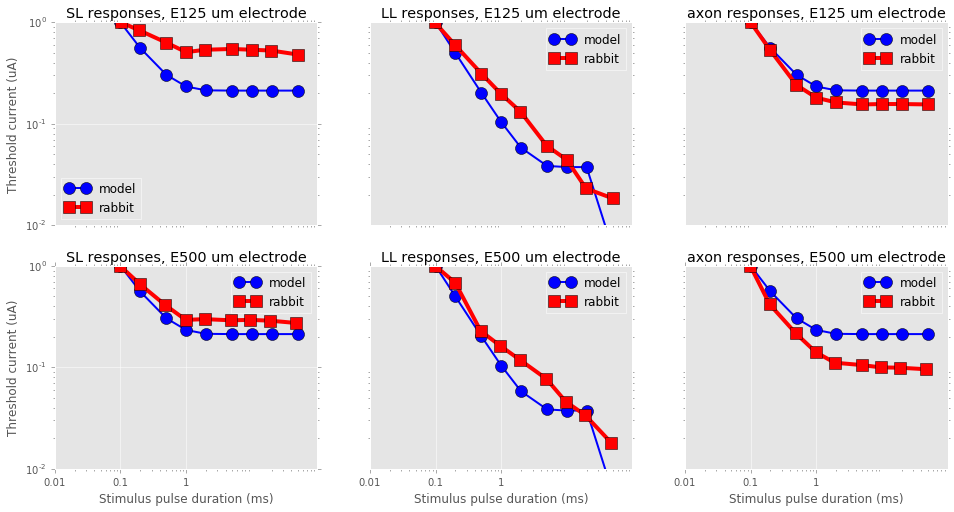

In [16]:
plt.figure(figsize=(16, 8))

subplot = 1
for ename in ['E125', 'E500']:
    for rtype in ['SL', 'LL', 'axon']:
        plt.subplot(2, 3, subplot)
        if ename in model:
            if rtype in model[ename]:
                plt.loglog(model[ename]['pulsedur'], np.array(model[ename][rtype]) / model[ename][rtype][0],
                           'o-b', linewidth=2, markersize=12, label='model')
        plt.loglog(jensen[ename][rtype][:, 0], jensen[ename][rtype][:, 1] / jensen[ename][rtype][0, 1],
                   's-r', linewidth=4, markersize=12, label='rabbit')
        
        if subplot > 3:
            plt.xticks(np.array([0.01, 0.1, 1]) / 1000, [0.01, 0.1, 1])
            plt.xlabel('Stimulus pulse duration (ms)')
        else:
            plt.xticks([])
        if (subplot - 1) % 3 == 0:
            plt.yticks([0.01, 0.1, 1])
            plt.ylabel('Threshold current (uA)')
        else:
            plt.yticks([])
        plt.title('%s responses, %s um electrode' % (rtype, ename))
        plt.legend(loc='best')
        plt.ylim(0.01, 1)
        plt.xlim(0.01 / 1000, 100.0 / 1000)
        
        subplot += 1

# Example response
--------------------------

In [10]:
tsample = 0.005 / 1000
resample = 2
pulse = e2cm.get_monophasic_pulse('cathodic', 0.001, tsample,
                                  delay_dur=0.02, stim_dur=0.1)
stim = TimeSeries(tsample, pulse)
tm = GanglionCellResponse(tsample=tsample, tau_inl=1.0 / 1000, lweight=0.1)
mov = ec2b.pulse2percept(stim, model['E125']['implant'], tm, retina,
                         ecs_scale=0.7,
                         use_ecs=False, engine='joblib', rsample=resample)
stim.resample(resample)

In [11]:
sl_max, ll_max = find_sl_ll(mov, stim, tm, True)

stim onset: dur=0.020000, idx=1999
SL=0.603121 at t=0.021000, LL=0.016426 at t=0.061580


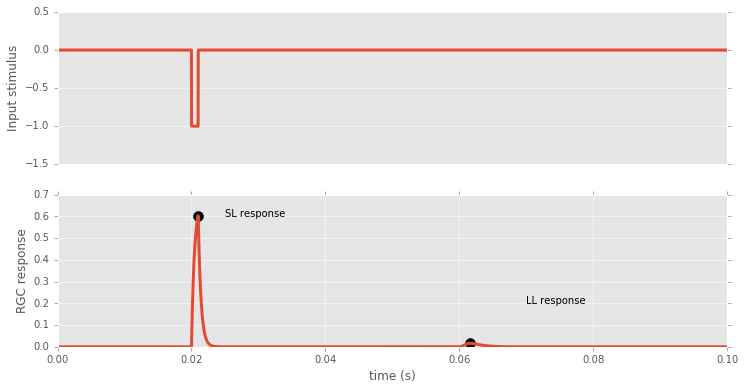

In [12]:
num_data = 10000
t = np.arange(0, num_data) * 0.005 / 1000 * resample
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(t, stim.data[:num_data], linewidth=3)
plt.xticks([])
plt.ylabel('Input stimulus')
plt.ylim(-1.5, 0.5)

plt.subplot(212)
plt.plot(sl_max[0], sl_max[1], 'ko', markersize=10)
plt.plot(ll_max[0], ll_max[1], 'ko', markersize=10)
plt.plot(t, mov.data[0, 0, :num_data], linewidth=3)
plt.xlabel('time (s)')
plt.ylabel('RGC response')
plt.text(0.025, 0.6, 'SL response')
plt.text(0.07, 0.2, 'LL response')